In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas, numpy, random
import matplotlib.pyplot as plt

In [7]:
from google.colab import drive
drive.mount('./mount')

Drive already mounted at ./mount; to attempt to forcibly remount, call drive.mount("./mount", force_remount=True).


In [8]:
class MnistDataset(Dataset):
  def __init__(self, csv_file):
    self.data_df = pandas.read_csv(csv_file, header=None)
    pass

  def __len__(self):
    return len(self.data_df)
  
  def __getitem__(self, index):
    label = self.data_df.iloc[index, 0]
    target = torch.zeros((10))
    target[label] = 1.0

    image_values = torch.FloatTensor(self.data_df.iloc[index, 1:].values)

    return label, image_values, target

  def plot_image(self, index):
    img = self.data_df.iloc[index, 1:].values.reshape(28, 28)
    plt.title("label = " + str(self.data_df.iloc[index, 0]))
    plt.imshow(img, interpolation = 'none', cmap = 'Blues')
    pass
  
  pass

In [9]:
mnist_dataset = MnistDataset('mount/My Drive/Colab Notebooks/myo_gan/mnist_data/mnist_train.csv')

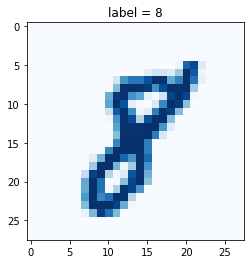

In [10]:
mnist_dataset.plot_image(17)

In [11]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(784, 200), 
        nn.Sigmoid(),
        nn.Linear(200, 1),
        nn.Sigmoid()
    )

    self.loss_function = nn.MSELoss()

    self.optimiser = torch.optim.SGD(self.parameters(), lr = 0.01)

    self.counter = 0
    self.progress = []

    pass

  def forward(self, inputs):
    return self.model(inputs)

  def train(self, inputs, targets):
    outputs = self.forward(inputs)

    loss = self.loss_function(outputs, targets)

    self.counter += 1
    if(self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
    if(self.counter % 10000 == 0):
      print("counter = ", self.counter)
      pass

    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns = ['loss'])
    df.plot(ylim=(0, 1.0), figsize = (16, 8), alpha = 0.1, marker = '.', grid = True, yticks = (0, 0.25, 0.5))
    pass

In [12]:
def generate_random(size):
    random_data = torch.rand(size)
    return random_data

In [15]:
%%time

D = Discriminator()

for label, image_data_tensor, target_tensor in mnist_dataset:
  D.train(image_data_tensor, torch.FloatTensor([1.0]))
  D.train(generate_random(784), torch.FloatTensor([0.0]))
  pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 2min, sys: 1.02 s, total: 2min 1s
Wall time: 2min


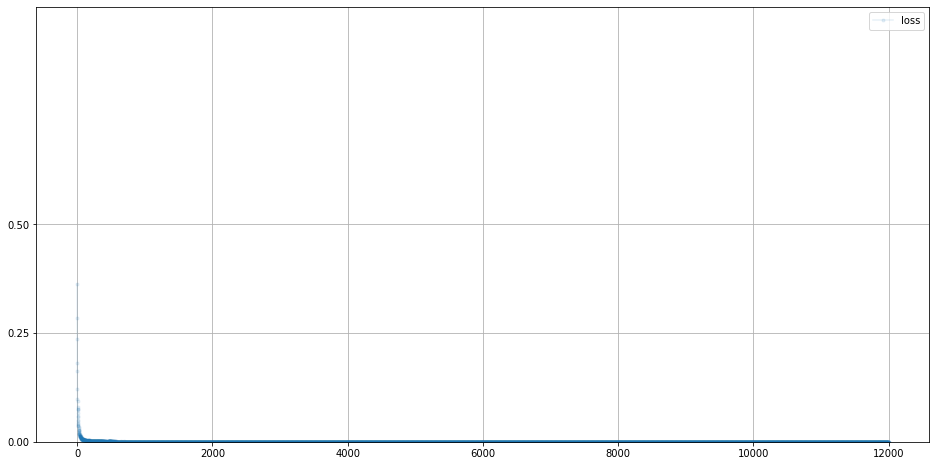

In [16]:
D.plot_progress()

In [17]:
for i in range(4):
  image_data_tensor = mnist_dataset[random.randint(0, 60000)][1]
  print(D.forward(image_data_tensor).item())
  pass

for i in range(4):
  print(D.forward(generate_random(784)).item())
  pass

0.9979202151298523
0.9962214231491089
0.9934067726135254
0.9966057538986206
0.004827253986150026
0.004311902914196253
0.004018958657979965
0.003755531506612897


In [18]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(1, 200), 
        nn.Sigmoid(),
        nn.Linear(200, 784),
        nn.Sigmoid()
    )

    self.optimiser = torch.optim.SGD(self.parameters(), lr = 0.01)

    self.counter = 0
    self.progress = []

    pass

  def forward(self, inputs):
    return self.model(inputs)

  def train(self, D, inputs, targets):
    g_output = self.forward(inputs)

    d_output = D.forward(g_output)

    loss = D.loss_function(d_output, targets)

    self.counter += 1
    if(self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass

    self.optimiser.zero_grad()
    loss.backward()
    self.optimiser.step()

    pass

  def plot_progress(self):
    df = pandas.DataFrame(self.progress, columns = ['loss'])
    df.plot(ylim=(0, 1.0), figsize = (16, 8), alpha = 0.1, marker = '.', grid = True, yticks = (0, 0.25, 0.5))
    pass

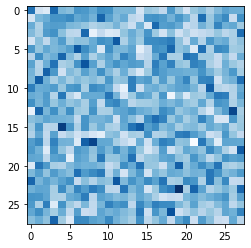

In [19]:
G = Generator()
output = G.forward(generate_random(1))
img = output.detach().numpy().reshape(28, 28)
plt.imshow(img, interpolation='none', cmap = 'Blues')

In [21]:
%%time

D = Discriminator()
G = Generator()

for label, image_data_tensor, target_tensor in mnist_dataset:
  D.train(image_data_tensor, torch.FloatTensor([1.0]))

  D.train(G.forward(generate_random(1)).detach(), torch.FloatTensor([0.0]))

  G.train(D, generate_random(1), torch.FloatTensor([1.0]))

  pass

counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
CPU times: user 3min 29s, sys: 2.52 s, total: 3min 32s
Wall time: 3min 32s


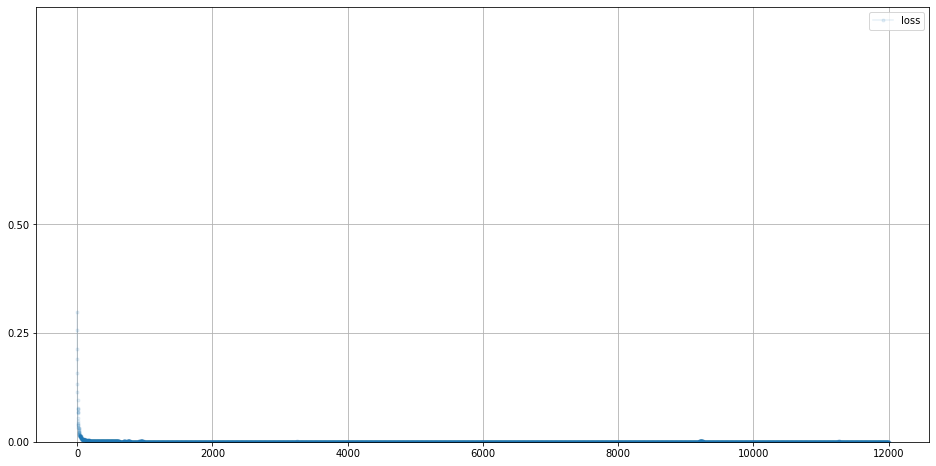

In [22]:
D.plot_progress()

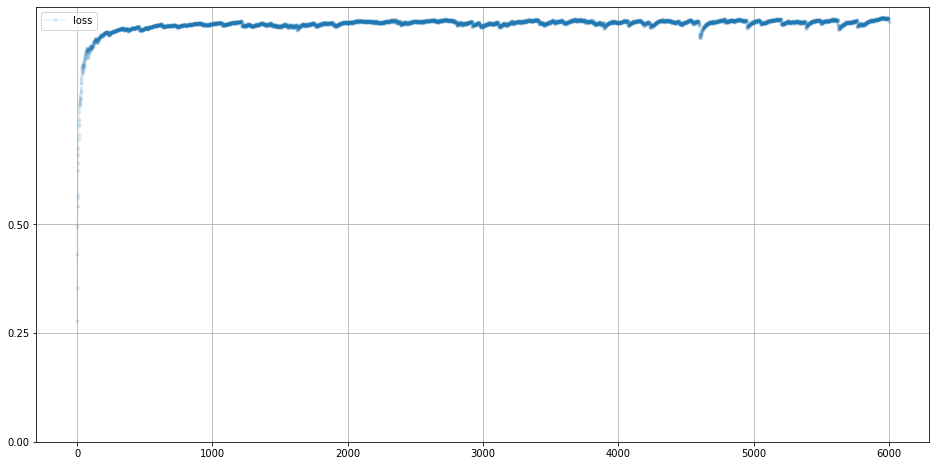

In [24]:
G.plot_progress()

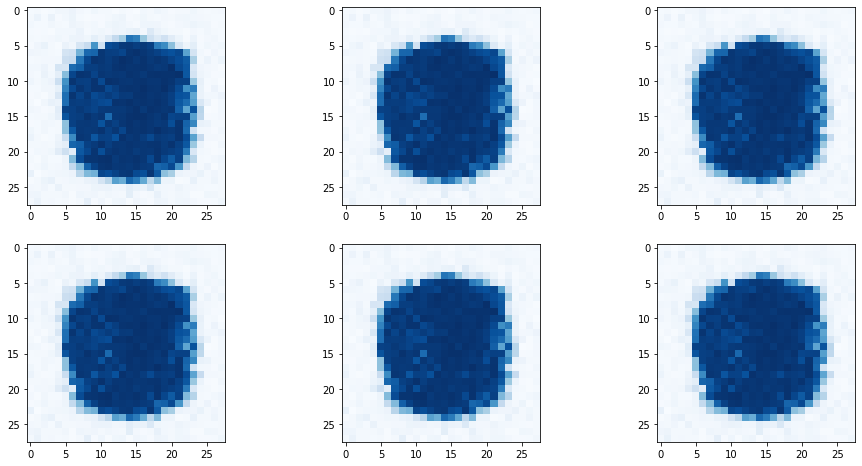

In [25]:
f, axarr = plt.subplots(2, 3, figsize = (16, 8))
for i in range(2):
  for j in range(3):
    output = G.forward(generate_random(1))
    img = output.detach().numpy().reshape(28, 28)
    axarr[i, j].imshow(img, interpolation='none', cmap='Blues')
    pass
  pass